In [31]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from matplotlib.patches import Patch
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict
import matplotlib.ticker as ticker

from utils import *

In [32]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=20)
matplotlib.rc("ytick", labelsize=20)

In [33]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True

In [34]:
agents = ['crl_search', 'cmd_search']
grid_sizes = [6]


def grouping_func(config):
    result = ''
    if config['agent']['agent_name'] == 'crl_search':
        result += 'CRL'
    else:
        result += 'CMD'
    
    if config['env']['number_of_moving_boxes_max'] == 2:
        result += '_1_on_target'
    elif config['env']['number_of_moving_boxes_max'] == 1:
        result += '_2_on_target'
    else:
        raise ValueError("Unknown number of moving boxes")

    return result

all_configs = []
boxes = [2, 1]
for box in boxes:
    for grid_size in grid_sizes:

        config = {
            "directory": "quasimetrics",
            "title": f"{box} boxes spawned on target" if box > 1 else f"{box} box spawned on target",
            "projects":["CMD-vs-CRL-generalized"],
            "possible_names":["CRL_1_on_target", "CMD_1_on_target", "CRL_2_on_target", "CMD_2_on_target", ],
            "filters":{
                # "config.agent.agent_name": agent,
                "config.env.grid_size": grid_size,
                "config.env.number_of_boxes_max": 3,
                "config.env.number_of_moving_boxes_max": box,
            },
            "grouping_func": grouping_func,
            "metrics": OrderedDict([
                ("eval/mean_success", "Training success on 3 boxes \n(1 or 2 on target)"), 
                ("eval_3/mean_success", "Test success on 3 boxes \n(0 on target)"),
            ]),
            "save": f"quasimetrics_{grid_size}_grid_{box}_boxes",
        }

        all_configs.append(config)


In [35]:
runs = []
for config in all_configs:
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])

In [36]:
len(all_configs)

2

In [37]:
# for config in all_configs:
#     runs = []
#     for project in config['projects']:
#         project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
#         runs.extend([r for r in project_runs])


#     data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
#     data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)

#     empty_keys = []
#     for k, v in data.items():
#         if v.size == 0:
#             empty_keys.append(k)

#     for k in empty_keys:
#         del data[k]

#     names = list(data.keys())

#     path = os.path.join(figures_path, config['directory'])
#     os.makedirs(path, exist_ok=True)

#     # draw_interval_estimates_plot(data, names, config['metrics'], config['title'], figures_path=path)
#     draw_curves_plot(data_curves, config['possible_names'], config['metrics'], config['title'] + "_curves", figures_path=path)

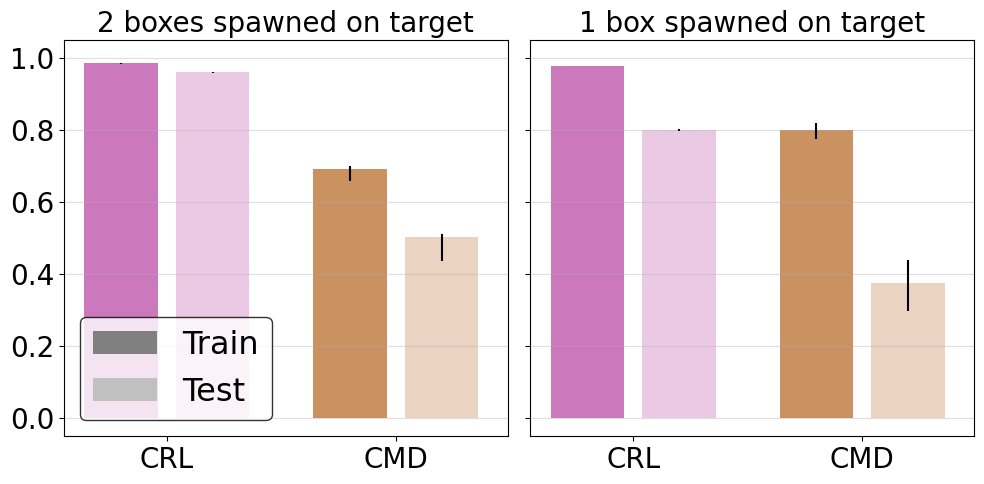

In [38]:

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey='row')
for config, ax in zip(all_configs, axs):
    # plt.title(config['title'])
    # fig.supylabel('Success rate', x=0.01)
    # fig.supxlabel(config['ylabel'], y=0.1)
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])

    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)


    empty_keys = []
    for k, v in data_curves.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data_curves[k]

    new_data = OrderedDict()

    for k, v in data_curves.items():
        aggregated_v = np.mean(v[:, -5:, :], axis=1)
        new_data[k + '_test'] = aggregated_v[:, 1].reshape(-1, 1)
        new_data[k + '_train'] = aggregated_v[:, 0].reshape(-1, 1)

    names = list(new_data.keys())

    metrics_names = config['metrics']

    figure_path = os.path.join(figures_path, config['directory'])
    os.makedirs(figure_path, exist_ok=True)

    aggregate_func = lambda x: np.array([metrics.aggregate_iqm(x[:, i]) for i in range(x.shape[-1])])

    aggregate_scores, aggregate_scores_cis = rly.get_interval_estimates(
        new_data, aggregate_func, reps=500
    )

    color_palette = sns.color_palette('colorblind')
    train_color = color_palette[0]
    test_color = color_palette[-1]

    agents = list(data_curves.keys())

    box_centers = []

    for idx, alg, color in zip(range(len(agents)), agents, color_palette):

        # ax.set_title(alg + (" (TD)" if alg == "GCDQN" else " (MC)"))
        ax.grid(alpha=0.4, axis='y')
        ax.set_ylim(bottom=-0.05, top=1.05)
        ax.set_title(config['title'], fontsize=20)

        box_center = 2.5 * idx + 0.5
        box_centers.append(box_center)
        # ax.axvspan(box_center - 1, box_center, color='palegreen', alpha=0.25)
        ax.axvspan(box_center, box_center + 1, color='white', alpha=1.0, hatch='/')
        train_score = aggregate_scores['_'.join([alg, 'train'])]
        test_score = aggregate_scores['_'.join([alg, 'test'])]
        # ax.hlines(train_score, xmin=box_center - 1, xmax=box_center, color='black')
        # ax.hlines(,  xmin=box_center, xmax=box_center+1, color='black')

        alg_name = '_'.join(alg, )
        train_bottom = aggregate_scores_cis['_'.join([alg, 'train'])][0]
        train_top = aggregate_scores_cis['_'.join([alg, 'train'])][1]

        test_bottom = aggregate_scores_cis['_'.join([alg, 'test'])][0]
        test_top = aggregate_scores_cis['_'.join([alg, 'test'])][1]

        train_color=return_color(alg, train=True)
        test_color=return_color(alg, train=False)
        ax.bar(box_center - 0.5, train_score, yerr=(train_score - train_bottom, train_top - train_score), color=train_color)
        ax.bar(box_center + 0.5, test_score, yerr=(test_score - test_bottom, test_top - test_score), color=test_color)

        if train_score <= 0.01:
            ax.hlines(train_score, xmin=box_center - 0.9, xmax=box_center-0.1, color=train_color)

        if test_score <= 0.01:
            ax.hlines(test_score, xmin=box_center+0.1, xmax=box_center+0.9, color=test_color)


    ax.set_xticks(np.array(box_centers), [a[:3] for a in agents])
    ax.set_yticks(np.arange(0, 1.1, 0.2))


legend_train_color = 'gray'
legend_test_color = lighten_color('gray', amount=0.5)
legend_elements = [Patch(facecolor=legend_train_color, label='Train'), Patch(facecolor=legend_test_color, label='Test')]
axs[0].legend(handles=legend_elements, edgecolor='black', loc='lower left', fontsize=23)



plt.tight_layout()


plt.savefig(os.path.join(figure_path, all_configs[0]['save']) + '.png',bbox_inches='tight')
plt.savefig(os.path.join(figure_path, all_configs[0]['save']) + '.pdf',bbox_inches='tight')